# Prerequisites

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


# Load Excel File

In [158]:
import pandas as pd
master_df = pd.read_excel('./DATASETS/Training_Dataset.xlsx')
master_df.head()

,Type,Identity,Text,A2-Unambiguous,A4-Tolerances,A5-Sources specified,E1
0,ast_adc,HLRS_1747,Massive Data Broadcast shall immediately send ...,1,na,1,1
1,ast_adc,HLRS_6673,Massive Data Broadcast shall place a copied Re...,1,na,1,1
2,ast_adc,HLRS_2470,Massive Data Broadcast shall place a copied Ma...,1,na,1,1
3,ast_adc,HLRS_2467,Massive Data Broadcast shall send the current ...,1,na,na,1
4,ast_adc,HLRS_2468,Massive Data Broadcast shall send the current ...,1,na,na,1


In [159]:
model_df = master_df[['E1','Text']].copy()
model_df.head()

,E1,Text
0,1,Massive Data Broadcast shall immediately send ...
1,1,Massive Data Broadcast shall place a copied Re...
2,1,Massive Data Broadcast shall place a copied Ma...
3,1,Massive Data Broadcast shall send the current ...
4,1,Massive Data Broadcast shall send the current ...


In [160]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330 entries, 0 to 3329
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E1      3330 non-null   int64 
 1   Text    3330 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.2+ KB


In [161]:
model_df_label1 = model_df.query('E1 == 1')
len(model_df_label1)

2133

In [162]:
model_df_label0 = model_df.query('E1 == 0')
len(model_df_label0)

1197

In [163]:
model_df = pd.concat([model_df_label1[:1500],model_df_label0])

# Data process and tokenizer

In [164]:
from sklearn.model_selection  import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.1, shuffle=True)

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [165]:
len(train_df)

2427

In [166]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Dataset iterator

In [167]:
from sklearn.model_selection  import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.1, shuffle=True)

In [168]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [169]:
next(train_iter)

(1,
 'The ePump Software shall set the SIGNAL VALUE for Fault ID 37- No fault: ePump is operating correctly when the [SET CONDITION(S) are true] and [the EPUMP STATE is Idle].')

In [170]:
def max_length(tensor):
    return max(len(t) for t in tensor)

#max_length_input = max_length(input_tensor)

def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
        
    return padded

#input_tensor = [pad_sequences(x, max_length_input) for x in input_tensor]

In [171]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [172]:
from torch.utils.data import DataLoader

MAX_LENGTH = 200

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = text_pipeline(_text)
        padded = pad_sequences(processed_text, MAX_LENGTH)
        text_list.append(padded)
        
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.tensor(text_list, dtype=torch.long)
    return label_list.to(device), text_list.to(device)

In [173]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
first = next(train_iter)
second = next(train_iter)

label, text = collate_batch([first, second])

print(label)
print(text)


tensor([1, 1], device='cuda:0')
tensor([[   1,   19,    8,    3,   24,    1,   86,   65,   12,   17,   37, 1876,
           84,   17,   19,   11,  261,  385,   16,    1,  335,  103,   15,   61,
           14,   38,  127,    9,  112,   19,   51,   11,  309,    2,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   

# Define the model

In [174]:
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden, layers, num_classes, dropout):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size,
                                            embedding_dim=embed_size)
        
        self.dropout = nn.Dropout(0.5)
        
        self.rnn = nn.GRU(input_size= embed_size,
                            hidden_size=hidden,
                            num_layers=layers,
                            batch_first=True,
                            bidirectional=True, # First train only one direction as a baseline
                            dropout=dropout
                           )

        self.fc = nn.Linear(in_features=hidden*2, out_features=num_classes) # Double the size of hidden neurons to account for the reverse pass

    def forward(self, x):
        embedded = self.embedding_layer(x)
        y, h = self.rnn(embedded)
        y = self.dropout(y)
        return self.fc(y[:,-1]) # Only use output for last timestep. The reason is because this is a classification problem.

In [175]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

2

In [176]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 200
hidden_size = 64
num_layers = 3
dropout = 0.1
model = GRU_Model(vocab_size, emsize, hidden_size, num_layers, num_class, dropout)

In [177]:
model

GRU_Model(
  (embedding_layer): Embedding(4242, 200)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): GRU(200, 64, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

# Train and eval functions

In [178]:
from datetime import datetime, date
import time

def train(model, dataloader, epoch):
    
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0


    for idx, (label, text) in enumerate(dataloader):         
        # if len(text) < BATCH_SIZE * MAX_LENGTH:
        #     continue # Skip incomplete batch
        
        # text = text.reshape(BATCH_SIZE, MAX_LENGTH)
        optimizer.zero_grad()
        
        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f} | {}".format(
                    epoch, idx, len(dataloader), total_acc / total_count, datetime.now().isoformat()
                )
            )
            start_time = time.time()
        
     
        
    return total_acc / total_count, total_loss / total_count
        

def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):      
            # if len(text) < BATCH_SIZE * MAX_LENGTH:
            #     continue # Skip incomplete batch

            # text = text.reshape(BATCH_SIZE, MAX_LENGTH)
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

# Split the dataset and run the model

In [179]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

BATCH_SIZE = 64  # batch size for training

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.8)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [180]:
today = date.today().isoformat()

# Hyperparameters
EPOCHS = 20  # epoch
LR = 1  # learning rate
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    
def train_with_hist(model, checkpoint_path = './models/simple_embeddings_baseline'):
    model = model.to(device)
    
    total_accu = None

    loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = [], [], [], []
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train(model, train_dataloader, epoch)
        accu_val, loss_val = evaluate(model, valid_dataloader)
        if total_accu is not None and total_accu > accu_val:
            scheduler.step()
            print("Learning rate took a step by the scheduler {:8.3f} > {:8.3f}".format(total_accu, accu_val))
        else:
            total_accu = accu_val
        print("-" * 59)
        print(
            "| end of epoch {:3d} | time: {:5.2f}s | "
            "valid accuracy {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, accu_val
            )
        )
        print("-" * 59)

        loss_hist_train.append(loss_train)
        loss_hist_valid.append(loss_val)
        accuracy_hist_train.append(accu_train)
        accuracy_hist_valid.append(accu_val)
        
    torch.save(model, f'{checkpoint_path}/{today}_bidirectional_gru.pt')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [181]:
hist = train_with_hist(model, './models/bidirectional_gru')

| epoch   1 |     5/   31 batches | accuracy    0.531 | 2024-04-11T12:19:50.632459
| epoch   1 |    10/   31 batches | accuracy    0.521 | 2024-04-11T12:19:50.667288
| epoch   1 |    15/   31 batches | accuracy    0.529 | 2024-04-11T12:19:50.702615
| epoch   1 |    20/   31 batches | accuracy    0.524 | 2024-04-11T12:19:50.737887
| epoch   1 |    25/   31 batches | accuracy    0.521 | 2024-04-11T12:19:50.772583
| epoch   1 |    30/   31 batches | accuracy    0.521 | 2024-04-11T12:19:50.805582
-----------------------------------------------------------
| end of epoch   1 | time:  0.24s | valid accuracy    0.477 
-----------------------------------------------------------
| epoch   2 |     5/   31 batches | accuracy    0.487 | 2024-04-11T12:19:50.864966
| epoch   2 |    10/   31 batches | accuracy    0.493 | 2024-04-11T12:19:50.899487
| epoch   2 |    15/   31 batches | accuracy    0.494 | 2024-04-11T12:19:50.933176
| epoch   2 |    20/   31 batches | accuracy    0.501 | 2024-04-11T12:19

In [182]:
import numpy as np
import matplotlib.pyplot as plt
def plot_learning_curves(hist):
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

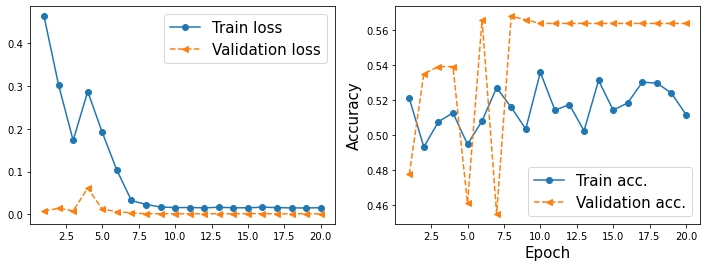

In [183]:
plot_learning_curves(hist)

### Evaluate the model with test dataset

Checking the results of the test dataset…



In [184]:
print("Checking the results of test dataset.")
accu_test, _ = evaluate(model, test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.522


In [185]:
# create confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_test = np.asarray([])
    y_predict = np.asarray([])

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            # if len(text) < BATCH_SIZE * MAX_LENGTH:
            #     continue # Skip incomplete batch

            # text = text.reshape(BATCH_SIZE, MAX_LENGTH)
            predicted_label = model(text)
                  
            y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=torch.long))), axis=None)
            y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=torch.long)))), axis=None)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt = "d")
    print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.67      0.05      0.09       132
         1.0       0.52      0.98      0.68       138

    accuracy                           0.52       270
   macro avg       0.59      0.51      0.38       270
weighted avg       0.59      0.52      0.39       270



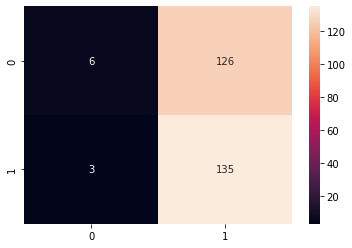

In [186]:
plot_confusion_matrix(model, test_dataloader)

In [187]:
def predict(text):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text)).to('cpu')
        padded = torch.tensor(pad_sequences(text, MAX_LENGTH), dtype=torch.long).to(device)
        output = model(padded.unsqueeze(0))
        return output.argmax(1).item()

In [188]:
ex_text_str = 'The ePump Software shall define Fault ID 1 as follows:'

print("This is a %s" % predict(ex_text_str))

This is a 1


In [189]:
pred_text = "The IO Service shall select the XLR-PW DEV_INFO_DATA file if HPP_XLR_WIRING is grounded (logical 1) and bits AC_TYPE_BIT1 - AC_TYPE_BIT6 do not indicate a CFM engine configuration. NOTE: HPP_XLR_WIRING and bits AC_TYPE_BIT[1-6] are discrete inputs which are received on constant pins between hardware configurations. See 282100-ICD-x for more details."
predict(pred_text)

1

In [190]:
pred_text = "When [transitioning from the Idle state to the Run state] the Epump Software shall change the motor configuration according to the attached image."
predict(pred_text)

1

# Hyperparameter tunning with Ray Tune

In [191]:
import time
from datetime import datetime, date

import ray
import ray.train.torch

from ray import train, tune
from ray.train import RunConfig, ScalingConfig, Checkpoint
from ray.train.torch import TorchTrainer

from ray.tune.schedulers import ASHAScheduler

In [192]:
ray.train.torch.get_device()

device(type='cuda', index=0)

In [193]:
from torch.utils.data import DataLoader

MAX_LENGTH = 200

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = text_pipeline(_text)
        padded = pad_sequences(processed_text, MAX_LENGTH)
        text_list.append(padded)
        
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.tensor(text_list, dtype=torch.long)
    return label_list, text_list

In [194]:
def train_func(model, optimizer, train_loader, max_norm):  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0

    for idx, (label, text) in enumerate(train_loader):           
        label, text = label.to(device), text.to(device)
        
        optimizer.zero_grad()
        
        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
         
    return total_acc / total_count, total_loss / total_count
        

def eval_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(data_loader):
            label, text = label.to(device), text.to(device)
            
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

In [195]:
import os
import tempfile

today = date.today().isoformat()
checkpoint_path = "./models/bidirectional_gru"
model_name = "bidirectional_gru"
num_class = 2
vocab_size = len(vocab)


def train_search(config):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    # print(device)
    # print(config)
    # config_params = config["params"]
    config_params = config
    # print(config_params)
    
    
    
    model = GRU_Model(vocab_size, 
                      config_params["embed_dim"], 
                      config_params["hidden_size"], 
                      config_params["num_layers"], 
                      num_class,
                      config_params["dropout"], 
                     )
    model = model.to(device)
    
    

    train_dataloader = DataLoader(
        split_train_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    valid_dataloader = DataLoader(
        split_valid_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    
    # optimizer = torch.optim.Adam(model.parameters(), lr=config_params["lr"])
    optimizer = torch.optim.SGD(model.parameters(), lr=config_params["lr"], momentum=config_params["momentum"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config_params["step_size"], gamma=config_params["lr_gamma"])
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(1, config_params["epochs"] + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train_func(model, optimizer, train_dataloader, config_params["max_norm"])
        accu_val, loss_val = eval_func(model, valid_dataloader)
        
        # Always let the scheduler take a step because it will be optimized by Hyperopt
        scheduler.step()
            
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if epoch % 5 == 0:
                # This saves the model to the trial directory
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            # Send the current training result back to Ray Tune
            train.report({
                "loss_train": loss_train,
                "loss_val": loss_val,
                "accuracy_train": accu_train,
                "accuracy_val": accu_val,
            }, checkpoint=checkpoint)

In [196]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [197]:
import numpy as np
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

exp_name = "bidirectional_gru"

space = {
    "lr": hp.loguniform("lr", -4, 1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
    "embed_dim": hp.choice("embed_dim", [200, 300, 400, 500]),
    "hidden_size": hp.choice("hidden_size", [32, 64, 128]), 
    "num_layers": hp.randint("num_layers", 3, 10),
    "epochs": hp.choice("epochs", [30]),
    "batch_size": hp.choice("batch_size", [16, 32]),
    "step_size": hp.randint("step_size", 1, 10),
    "lr_gamma": hp.uniform("lr_gamma", 0.1, 0.9),
    "max_norm": hp.uniform("max_norm", 0.1, 0.9),
    "dropout": hp.uniform("dropout", 0.1, 0.9),
}

hyperopt_search = HyperOptSearch(space, metric="accuracy_val", mode="max")

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

tuner = tune.Tuner(
    tune.with_resources(train_search, resources={"cpu":8, "gpu":0.5}),
    tune_config=tune.TuneConfig(
        num_samples=50,
        scheduler=ASHAScheduler(metric="accuracy_val", mode="max"), # Early stopping
        search_alg=hyperopt_search, # Hyperopt library for Hyper-parameter Optimization
    ),
    run_config=train.RunConfig(
        name=exp_name,
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="accuracy_val",
            num_to_keep=2,
            # checkpoint_at_end=True
        ),
    ),
)
results = tuner.fit()

(train_search pid=27866) /tmp/ipykernel_23042/2942370405.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
(train_search pid=27926) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/bidirectional_gru/train_search_9a4121ef_2_batch_size=32,dropout=0.7661,embed_dim=400,epochs=30,hidden_size=128,lr=0.2093,lr_gamma=0.1981,max_norm=0._2024-04-11_12-20-23/checkpoint_000000)
(train_search pid=27926) /tmp/ipykernel_23042/2942370405.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
(train_search pid=27926) Checkpoint successfully cre

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

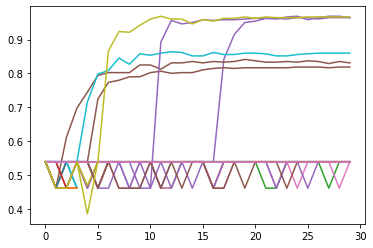

In [198]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d["accuracy_val"].plot() for d in dfs.values()]

In [145]:
best_result = results.get_best_result("accuracy_val", "max")
best_result.config

{'batch_size': 32,
 'dropout': 0.3729034419017242,
 'embed_dim': 400,
 'epochs': 30,
 'hidden_size': 128,
 'lr': 2.2120847471114953,
 'lr_gamma': 0.3957210377723951,
 'max_norm': 0.7862651581831464,
 'momentum': 0.38130695941059256,
 'num_layers': 6,
 'step_size': 2}

In [146]:
best_result.metrics_dataframe

,loss_train,loss_val,accuracy_train,accuracy_val,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,...,config/embed_dim,config/epochs,config/hidden_size,config/lr,config/lr_gamma,config/max_norm,config/momentum,config/num_layers,config/step_size,should_checkpoint
0,0.118456,0.005329,0.489481,0.476636,1712856510,None,False,1,ebfd3d1f,2024-04-11_10-28-30,...,400,30,128,2.212085,0.395721,0.786265,0.381307,6,2,NaN
1,0.130707,0.008789,0.489949,0.523364,1712856511,None,False,2,ebfd3d1f,2024-04-11_10-28-31,...,400,30,128,2.212085,0.395721,0.786265,0.381307,6,2,NaN
2,0.056207,0.001619,0.501169,0.476636,1712856513,None,False,3,ebfd3d1f,2024-04-11_10-28-33,...,400,30,128,2.212085,0.395721,0.786265,0.381307,6,2,NaN
3,0.029906,0.001067,0.563815,0.790654,1712856516,None,False,4,ebfd3d1f,2024-04-11_10-28-36,...,400,30,128,2.212085,0.395721,0.786265,0.381307,6,2,NaN
4,0.021497,0.000858,0.643759,0.523364,1712856518,checkpoint_000000,False,5,ebfd3d1f,2024-04-11_10-28-38,...,400,30,128,2.212085,0.395721,0.786265,0.381307,6,2,True
5,0.019049,0.000561,0.682562,0.904673,1712856521,None,False,6,ebfd3d1f,2024-04-11_10-28-41,...,400,30,128,2.212085,0.395721,0.786265,0.381307,6,2,NaN
6,0.014607,0.000805,0.801777,0.878505,1712856524,None,False,7,ebfd3d1f,2024-04-11_10-28-44,...,400,30,128,2.212085,0.395721,0.786265,0.381307,6,2,NaN
7,0.013064,0.000895,0.842917,0.908411,1712856527,None,False,8,ebfd3d1f,2024-04-11_10-28-47,...,400,30,128,2.212085,0.395721,0.786265,0.381307,6,2,NaN
8,0.009528,0.000363,0.920056,0.910280,1712856530,None,False,9,ebfd3d1f,2024-04-11_10-28-50,...,400,30,128,2.212085,0.395721,0.786265,0.381307,6,2,NaN
9,0.008728,0.000483,0.931744,0.912150,1712856532,checkpoint_000001,False,10,ebfd3d1f,2024-04-11_10-28-52,...,400,30,128,2.212085,0.395721,0.786265,0.381307,6,2,True


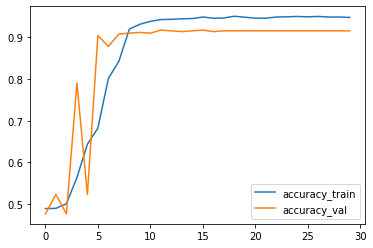

In [147]:
import matplotlib.pyplot as plt

df = best_result.metrics_dataframe

plt.plot(df['accuracy_train'], label='accuracy_train')
plt.plot(df['accuracy_val'], label='accuracy_val')

plt.legend(title='')

plt.show()

In [148]:
best_checkpoints = best_result.best_checkpoints
best_checkpoints

[(Checkpoint(filesystem=local, path=/home/it/ray_results/bidirectional_gru/train_search_ebfd3d1f_1_batch_size=32,dropout=0.3729,embed_dim=400,epochs=30,hidden_size=128,lr=2.2121,lr_gamma=0.3957,max_norm=0._2024-04-11_10-28-27/checkpoint_000004),
  {'loss_train': 0.006459359036059288,
   'loss_val': 0.0004666092518334077,
   'accuracy_train': 0.9504441327723235,
   'accuracy_val': 0.9158878504672897,
   'timestamp': 1712856575,
   'checkpoint_dir_name': 'checkpoint_000004',
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 25,
   'trial_id': 'ebfd3d1f',
   'date': '2024-04-11_10-29-35',
   'time_this_iter_s': 2.861696720123291,
   'time_total_s': 65.27701592445374,
   'pid': 25250,
   'hostname': 'coeus',
   'node_ip': '10.1.1.204',
   'config': {'batch_size': 32,
    'dropout': 0.3729034419017242,
    'embed_dim': 400,
    'epochs': 30,
    'hidden_size': 128,
    'lr': 2.2120847471114953,
    'lr_gamma': 0.3957210377723951,
    'max_norm': 0.7862651581831464,
  

In [149]:
best_result = results.get_best_result("accuracy_val", mode="max")
best_result

Result(
  metrics={'loss_train': 0.006787575044647005, 'loss_val': 0.0008627985125390169, 'accuracy_train': 0.9481065918653576, 'accuracy_val': 0.9158878504672897},
  path='/home/it/ray_results/bidirectional_gru/train_search_ebfd3d1f_1_batch_size=32,dropout=0.3729,embed_dim=400,epochs=30,hidden_size=128,lr=2.2121,lr_gamma=0.3957,max_norm=0._2024-04-11_10-28-27',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/home/it/ray_results/bidirectional_gru/train_search_ebfd3d1f_1_batch_size=32,dropout=0.3729,embed_dim=400,epochs=30,hidden_size=128,lr=2.2121,lr_gamma=0.3957,max_norm=0._2024-04-11_10-28-27/checkpoint_000005)
)

In [150]:
best_checkpoint = best_result.get_best_checkpoint("accuracy_val", mode="max")

In [151]:
next(x for x in best_checkpoints if x[0].path == best_checkpoint.path)

(Checkpoint(filesystem=local, path=/home/it/ray_results/bidirectional_gru/train_search_ebfd3d1f_1_batch_size=32,dropout=0.3729,embed_dim=400,epochs=30,hidden_size=128,lr=2.2121,lr_gamma=0.3957,max_norm=0._2024-04-11_10-28-27/checkpoint_000004),
 {'loss_train': 0.006459359036059288,
  'loss_val': 0.0004666092518334077,
  'accuracy_train': 0.9504441327723235,
  'accuracy_val': 0.9158878504672897,
  'timestamp': 1712856575,
  'checkpoint_dir_name': 'checkpoint_000004',
  'should_checkpoint': True,
  'done': False,
  'training_iteration': 25,
  'trial_id': 'ebfd3d1f',
  'date': '2024-04-11_10-29-35',
  'time_this_iter_s': 2.861696720123291,
  'time_total_s': 65.27701592445374,
  'pid': 25250,
  'hostname': 'coeus',
  'node_ip': '10.1.1.204',
  'config': {'batch_size': 32,
   'dropout': 0.3729034419017242,
   'embed_dim': 400,
   'epochs': 30,
   'hidden_size': 128,
   'lr': 2.2120847471114953,
   'lr_gamma': 0.3957210377723951,
   'max_norm': 0.7862651581831464,
   'momentum': 0.3813069594

In [152]:
state_dict = torch.load(os.path.join(best_checkpoint.path, "model.pth"))

num_class = 2
vocab_size = len(vocab)
model = GRU_Model(vocab_size, 
                      best_result.config["embed_dim"], 
                      best_result.config["hidden_size"], 
                      best_result.config["num_layers"], 
                      num_class,
                      best_result.config["dropout"], 
                     )
model.load_state_dict(state_dict)

<All keys matched successfully>

In [153]:
uq_path = today + "_" + "_".join(best_result.path.split("=")[0].split("/")[-2:])
save_path = os.path.join('./models/bidirectional_gru', uq_path + "_model.pt")

In [154]:
torch.save(model, save_path)

## Eval optimized model with test dataset

In [155]:
test_df = pd.read_excel('TestDataset.xlsx')
test_df = test_df[['E1','Text']]
#Convert E1 column values to integers
test_df['E1'] = test_df['E1'].astype(int)
test_df.head()

,E1,Text
0,1,The FA shall interpret each ARINC 429 word as ...
1,1,The FA shall identify the validity of the data...
2,0,The FA shall identify the validity of the data...
3,0,The FA shall interpret each ARINC 429 word as ...
4,1,The FA shall interpret bits 8-1 to indicate th...


In [156]:
from torchtext.data.functional import to_map_style_dataset

test_iter = iter(list(test_df.itertuples(index=False, name=None)))
test_dataset = to_map_style_dataset(test_iter)
    
test_dataloader = DataLoader(test_dataset,
                             batch_size=64,
                             shuffle=False,
                             collate_fn=collate_batch)

              precision    recall  f1-score   support

         0.0       0.54      0.67      0.60       210
         1.0       0.57      0.44      0.50       210

    accuracy                           0.55       420
   macro avg       0.56      0.55      0.55       420
weighted avg       0.56      0.55      0.55       420



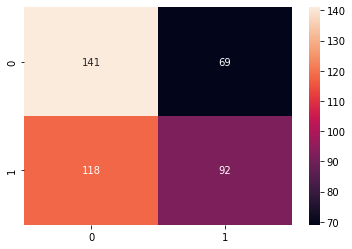

In [157]:
plot_confusion_matrix(model, test_dataloader)